In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import aplpy
import matplotlib.pyplot as plt
import pyregion
from tqdm import tqdm
from astropy.table import QTable
import warnings
import numpy as np
import imageio.v3 as iio
from reproject import reproject_interp
import astropy.units as u

from astropy.wcs import WCS
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from astropy.coordinates import SkyCoord
import colorcet

warnings.filterwarnings("ignore")
plt.style.use('paper')

In [2]:
# Load in the RGB image from Spitzer and convert it to a FITS file

inputfile_rgb_fits = './data/cutout-IPAC_P_GLIMPSE360.fits'
inputfile_rgb_png = './data/cutout-IPAC_P_GLIMPSE360.jpg'
hdu_rgb = fits.open(inputfile_rgb_fits)[0]
hdu_rgb.data = hdu_rgb.data[0]
hdu_rgb.header['NAXIS'] = 2
del hdu_rgb.header['*3*']
del hdu_rgb.header['*4*']

hdr_rgb = hdu_rgb.header.copy()

file_rgb = './data/ssc2006-02a1.jpg'

data_rgb = iio.imread(file_rgb)
data_rgb = data_rgb[:,:,2]
data_rgb = data_rgb[::-1]

hdr_rgb['CRPIX1'] = data_rgb.shape[1]/2
hdr_rgb['CRPIX2'] = data_rgb.shape[0]/2

hdr_rgb['CRVAL1'] = 0 - 0.031
hdr_rgb['CRVAL2'] = 0 + 0.003

l1 = 0.9359
l2 = 358.991 - 360
b1 = -0.69619
b2 = 0.7

w, h = l1 - l2, b2 - b1

hdr_rgb['CDELT1'] = -w/data_rgb.shape[1]
hdr_rgb['CDELT2'] = h/data_rgb.shape[0]

hdu_rgb_new = fits.PrimaryHDU(data=data_rgb, header=hdr_rgb)
hdu_rgb_new.writeto(file_rgb.replace('jpg', 'fits'), overwrite=True)

In [3]:
# Load in the RGB image from PPVII image and fits file

inputfile_rgb_fits1 = '/Users/abarnes/Dropbox/work/Smallprojects/ppVII/review/cover/data_regrid/hershel160.fits'
inputfile_rgb_png1 = '/Users/abarnes/Dropbox/work/Smallprojects/ppVII/review/cover/rgb_final_uncropped.jpeg'
hdu_rgb1 = fits.open(inputfile_rgb_fits1)[0]

In [4]:
# Load in the spetral line data from ACES 

# hdu_max = fits.open('./data_aces/HC3N_CubeMosaic_downsampled9_spectrally.fits.moment.maximum')[0]
# hdu_mom1 = fits.open('./data_aces/HC3N_CubeMosaic_downsampled9_spectrally.fits.moment.maximum_coord')[0]

hdu_max = fits.open('./data_aces/HNCO_7m12mTP_CubeMosaic_downsampled9.fits.moment.maximum')[0]
# hdu_mom1 = fits.open('./data_aces/HNCO_7m12mTP_CubeMosaic_downsampled9.fits.moment.maximum_coord')[0]
hdu_mom1 = fits.open('./data_aces/HNCO_7m12mTP_CubeMosaic_downsampled9.fits.moment.weighted_coord')[0]

In [5]:
# Reproject the lines to the same grid as the RGB image

hdu_max_reproject = fits.PrimaryHDU(reproject_interp(hdu_max, hdu_rgb_new.header)[0], header=hdu_rgb.header)
hdu_mom1_reproject = fits.PrimaryHDU(reproject_interp(hdu_mom1, hdu_rgb_new.header)[0], header=hdu_rgb.header)

hdu_max_reproject1 = fits.PrimaryHDU(reproject_interp(hdu_max, hdu_rgb1.header)[0], header=hdu_rgb1.header)
hdu_mom1_reproject1 = fits.PrimaryHDU(reproject_interp(hdu_mom1, hdu_rgb1.header)[0], header=hdu_rgb1.header)

In [6]:
def get_cmap(cmap = mpl.cm.afmhot):
    my_cmap = cmap(np.arange(cmap.N))
    # Set alpha
    my_cmap[:,-1] = np.linspace(0, 1, cmap.N)
    # Create new colormap
    my_overlay = ListedColormap(my_cmap)
    return(my_overlay)

In [7]:
def NormalizeData(data):
    data_norm = (data - np.nanmin(data)) / (np.nanmax(data) - np.nanmin(data))
    data_norm[np.isnan(data)] = 0
    return data_norm

In [8]:
wcs = WCS(hdu_rgb_new.header)
xlim1_world = -0.65 
ylim1_world = -0.5
xlim2_world = 0.9
ylim2_world = 0.5

xlim1, ylim1 = wcs.world_to_pixel(SkyCoord(xlim1_world, ylim1_world, unit=(u.deg, u.deg), frame='galactic'))
xlim2, ylim2 = wcs.world_to_pixel(SkyCoord(xlim2_world, ylim2_world, unit=(u.deg, u.deg), frame='galactic'))

In [9]:
# Define the colourmap
cmap1 = plt.cm.binary(np.linspace(0, 1, 32))
cmap2 = colorcet.cm.fire(np.linspace(0, 1, 128))
cmaplist = np.vstack((cmap1, cmap2))
cmap = mpl.colors.LinearSegmentedColormap.from_list('my_colormap', cmaplist)
cmap.set_under(cmap(0))
cmap.set_bad(color=cmap(0))

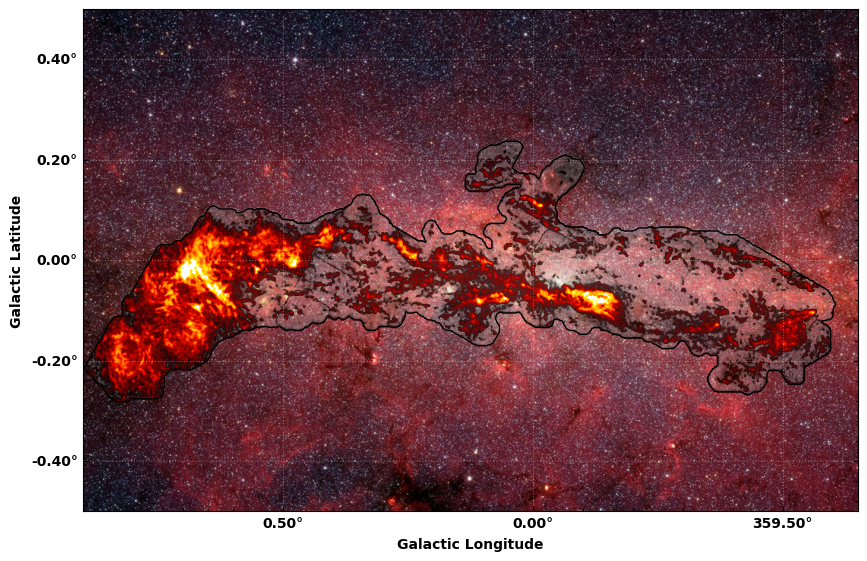

In [10]:
image = iio.imread(file_rgb)[::-1]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=WCS(hdu_rgb_new.header))

ax.imshow(image, origin='lower')

alpha = NormalizeData(np.sqrt(hdu_max_reproject.data))

for i in range(5):
    # ax.imshow(alpha, cmap=get_cmap(mpl.cm.inferno), vmin=0.05, vmax=0.7)
    # ax.imshow(alpha, cmap=get_cmap(mpl.cm.afmhot), vmin=0.05, vmax=0.7)
    ax.imshow(alpha, cmap=get_cmap(cmap), vmin=0.001, vmax=0.7)
    # ax.imshow(alpha, cmap=get_cmap(mpl.cm.gist_stern), vmin=0.05, vmax=0.7)
    # ax.imshow(alpha, cmap=get_cmap(mpl.cm.hot), vmin=0.05, vmax=0.7)
    # ax.imshow(alpha, cmap=get_cmap(mpl.cm.turbo), vmin=0.05, vmax=0.7)

ax.contour((alpha==0)*1, levels=[1], colors='black', linewidths=1)

ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

lon = ax.coords['glon']
lat = ax.coords['glat']

lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

lon.display_minor_ticks(True)
lat.display_minor_ticks(True)

ax.set_xlim(xlim2, xlim1)
ax.set_ylim(ylim1, ylim2)

ax.grid(True, alpha=0.3, ls=':', color='white')

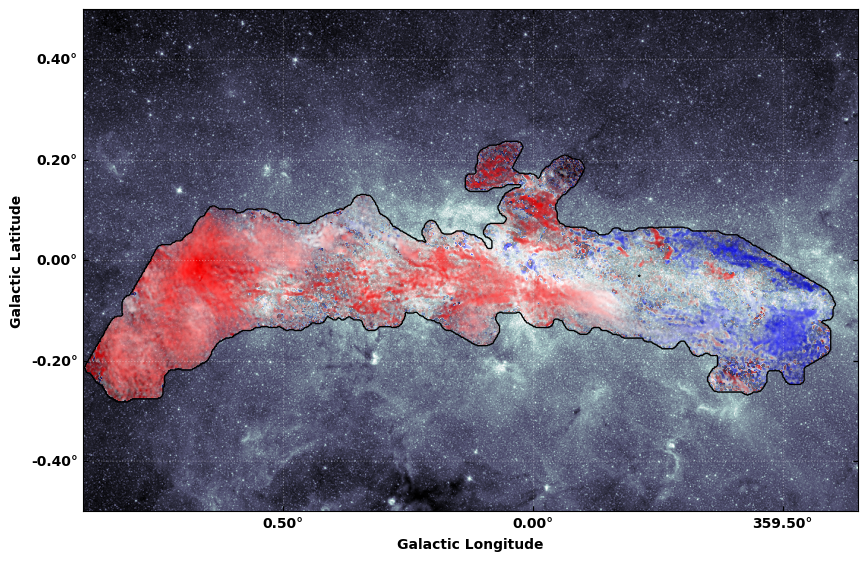

In [49]:
image = iio.imread(file_rgb)[::-1]

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=WCS(hdu_rgb_new.header))

# ax.imshow(image, origin='lower')
ax.imshow(image[:,:,0], origin='lower', cmap='bone')

alpha = NormalizeData(hdu_max_reproject.data**0.2)

for i in range(2):
    ax.imshow(hdu_mom1_reproject.data, cmap=mpl.cm.seismic, vmin=-150, vmax=150, alpha=alpha)
    # ax.imshow(hdu_mom1_reproject.data, cmap=mpl.cm.RdBu, vmin=-100, vmax=100, alpha=alpha)

ax.contour((alpha==0)*1, levels=[1], colors='black', linewidths=1)

ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

lon = ax.coords['glon']
lat = ax.coords['glat']

lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

ax.set_xlim(xlim2, xlim1)
ax.set_ylim(ylim1, ylim2)

ax.grid(True, alpha=0.3, ls=':', color='white')

In [12]:
wcs = WCS(hdu_rgb1.header)
xlim1_world = -0.85 
ylim1_world = -1.2
xlim2_world = 1.1
ylim2_world = 1.2

xlim1, ylim1 = wcs.world_to_pixel(SkyCoord(xlim1_world, ylim1_world, unit=(u.deg, u.deg), frame='galactic'))
xlim2, ylim2 = wcs.world_to_pixel(SkyCoord(xlim2_world, ylim2_world, unit=(u.deg, u.deg), frame='galactic'))

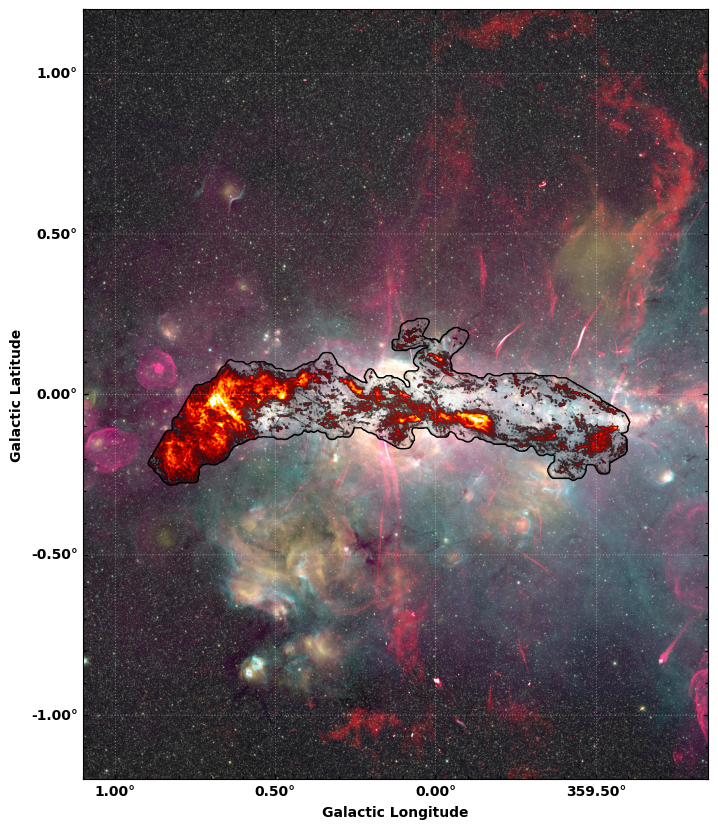

In [13]:
image = iio.imread(inputfile_rgb_png1)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=WCS(hdu_rgb1.header))

ax.imshow(np.flip(image, axis=0), origin='lower')

alpha = NormalizeData(np.sqrt(hdu_max_reproject1.data))

for i in range(5):
    # ax.imshow(alpha, cmap=get_cmap(mpl.cm.inferno), vmin=0.05, vmax=0.7)
    # ax.imshow(alpha, cmap=get_cmap(mpl.cm.afmhot), vmin=0.05, vmax=0.7)
    ax.imshow(alpha, cmap=get_cmap(cmap), vmin=0.001, vmax=0.7)
    # ax.imshow(alpha, cmap=get_cmap(mpl.cm.gist_stern), vmin=0.05, vmax=0.7)
    # ax.imshow(alpha, cmap=get_cmap(mpl.cm.hot), vmin=0.05, vmax=0.7)
    # ax.imshow(alpha, cmap=get_cmap(mpl.cm.turbo), vmin=0.05, vmax=0.7)

ax.contour((alpha==0)*1, levels=[1], colors='black', linewidths=1)

ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

lon = ax.coords['glon']
lat = ax.coords['glat']

lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

lon.display_minor_ticks(True)
lat.display_minor_ticks(True)

ax.set_xlim(xlim2, xlim1)
ax.set_ylim(ylim1, ylim2)

ax.grid(True, alpha=0.3, ls=':', color='white')

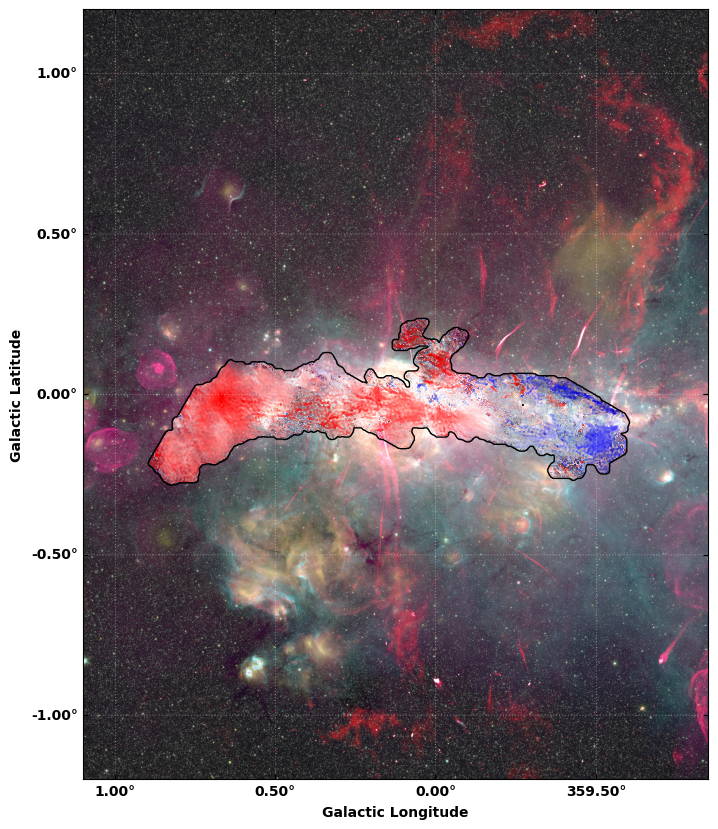

In [14]:
image = iio.imread(inputfile_rgb_png1)

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection=WCS(hdu_rgb1.header))

ax.imshow(np.flip(image, axis=0), origin='lower')

alpha = NormalizeData(np.sqrt(hdu_max_reproject1.data))

for i in range(5):
    ax.imshow(hdu_mom1_reproject1.data, cmap=mpl.cm.seismic, vmin=-150, vmax=150, alpha=alpha)
    # ax.imshow(hdu_mom1_reproject1.data, cmap=mpl.cm.RdBu, vmin=-100, vmax=100, alpha=alpha)

ax.contour((alpha==0)*1, levels=[1], colors='black', linewidths=1)

ax.set_xlabel('Galactic Longitude')
ax.set_ylabel('Galactic Latitude')

lon = ax.coords['glon']
lat = ax.coords['glat']

lon.set_major_formatter('d.dd')
lat.set_major_formatter('d.dd')

ax.set_xlim(xlim2, xlim1)
ax.set_ylim(ylim1, ylim2)

ax.grid(True, alpha=0.3, ls=':', color='white')